## Building a Bayesian Network for Diabetes

### Lorenzo Venieri , Luca Zucchini

## Introduction

Diabetes is a serious disease affecting millions of people across the entire world. Thus, correct and timely prediction of this disease is very important due to the complications it can have in the case of other life-threatening diseases. Diabetes can be diagnosed through observation of some clinical data, in particular blood glucose level. But if blood glucose level is used to diagnose diabetes, there are other factors (called risk factors) that can suggest, but not confirm, that a patient has diabetes. The latter consideration leads to the development of this project, where we will analyze different clinical data, to understand the impact of certain risk factors on the likelihood of developing diabetes in patients.

The objective of this project is therefore to apply the studied notions about Bayesian Networks, to implement a probabilistic model on a dataset built from patients with diabetes and to extrapolate the correlations between risk factors and diabetes.

## Dataset

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.
The Pima (or Akimel O'odham, "River People") are a group of Native Americans living in an area consisting of what is now central and southern Arizona, as well as northwestern Mexico in the states of Sonora and Chihuahua.
The diversion of the water and the introduction of non-native diet is said to have been the leading contributing factor in the high rate of diabetes among the Akimel Oʼodham tribe. They have the highest prevalence of type 2 diabetes in the world, much more than is observed in other U.S. populations.    
The general increased diabetes prevalence among Native Americans has been hypothesized as the result of the interaction of genetic predisposition and a sudden shift in diet during the last century from traditional agricultural crops to processed foods, together with a decline in physical activity.  
Between U.S. Pima indians, 34.2% of men and 40.8% of women suffer from diabetes as reported in https://doi.org/10.2337/dc06-0138.

From the dataset in the .csv file we can find several medical predictor variables and a target variable (Outcome), representhing whether the patient has diabetes or not. It must be emphasized that the dataset makes no distinction between type 1 Diabetes and type 2 Diabetes, during the analysis we tackle this by splitting the '1' values in the Outcome column into two different columns representing, respectively, type 1 and type 2 Diabetes.

We have 9 different attributes:
1. Pregnancies: number of pregnancies
2. Glucose: plasma glucose concentrarion 
3. BloodPressure: diastolic blood pressure mm/Hg
4. SkinThickness: triceps skin fold thickness (mm)
5. Insulin: insulin in U/mL
6. BMI: Body mass index (weight in kg/(height in m)^2)
7. Diabetes Pedigree Function: scores likelihood of diabetes based on family history
8. Age: age of the person (years)
9. Outcome: patient has diabetes (0 = No, 1 = Yes)

The dataset contains info about 768 patients.

In [ ]:
# %pip install pgmpy

In [500]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_raw = pd.read_csv("diabetes.csv")
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Exploratory Data Analysis

In [501]:
#Diabetes distribution in the dataset

df_raw['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In the dataset there are 268 patients with diabetes and 500 without. The Outcome column is imbalanced: only about 35% of the entries have diabetes. We will check, after the cleaning of the dataset, if this will still be the case. Moreover, the column "Outcome" represents the presence of diabetes in the patients without indication whether it takes in consideration type 1 Diabetes, type 2 Diabetes or both of them. To resolve this ambiguity we check if there are positives outcomes in rows with very low values of "Insulin": clear indication of type 1 Diabetes presence.

In [448]:
count = 0
for i in range(df_raw.shape[0]):
    if df_raw["Insulin"][i] < 1 and df_raw["Outcome"][i] == 1 :
        count += 1
print("In the dataset there are",count,"patients with type 1 diabetes among the total",df_raw["Outcome"].value_counts()[1],"patients with diabetes")

In the dataset there are 138 patients with type 1 diabetes among the total 268 patients with diabetes


We will deal with this "ambiguity" later on during the cleaning and preparation of the dataset.

## Data cleaning and preparation

In this chapter we take care of cleaning up the dataset. In particular, we ensure that the data can be used in a proper way by the model that we will use to perform our analysis.  
We will look for missing/null values and we will transform the data in order to model a bayesian network and to work with it. We will then need to create columns populated by bins starting from columns of continuous values, to perform parameter learning for our bayesian network.

In [449]:
df_raw.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [450]:
for item in df_raw.columns :
    if item != "Outcome":
        print("In the column", item,"there are",(df_raw[item].values == 0).sum(),"zero values")

In the column Pregnancies there are 111 zero values
In the column Glucose there are 5 zero values
In the column BloodPressure there are 35 zero values
In the column SkinThickness there are 227 zero values
In the column Insulin there are 374 zero values
In the column BMI there are 11 zero values
In the column DiabetesPedigreeFunction there are 0 zero values
In the column Age there are 0 zero values


In the dataset there are many null values appearing in the form of '0' rather than NaN. We need to underline that the assumption that a value '0' is a null value is obviously not general but it holds in this case since almost of all the columns cannot have a '0' value since it would make no sense (e.g. it is impossible to register a value of Glucose in the blood equal to 0).

We decided to remove them instead of using statistical methods to predict the missing values, since we have few data and we want them to be as much predictive as possible. By the way, we have to consider that zero values of Insulin are interesting as stated before.  

We proceed with the removal of rows that have a null value in the columns: 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI'.  
Previous analysis showed that DiabetesPedigreeFunction column and Age column don't contain any zero/null values.

In [451]:
df_clean = df_raw.copy(deep=True)

In [452]:
columns_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness','BMI'] 
#A zero value in these columns is surely an error since it's impossible to have value zero for these fetures
for item in columns_to_clean:
    drop_list = []
    for i in range(len(df_clean[item])):
        if df_clean[item][i] == 0 :
            drop_list.append(i)
    print("Column",item,"has been cleaned")
    df_clean.drop(labels= drop_list, axis= 0, inplace= True)
    df_clean.reset_index(drop=True, inplace=True)
    

Column Glucose has been cleaned
Column BloodPressure has been cleaned
Column SkinThickness has been cleaned
Column BMI has been cleaned


With regard to the Insulin column we consider the fact that a zero value of insulin in the blood is a sure sign of the presence of type 1 Diabetes, so we proceed with removing all the rows that have value '0' of both Insulin and Outcome, since it's impossible to have no insulin without having diabetes. (source: https://medlineplus.gov/lab-tests/insulin-in-blood/)

In [453]:
for i in range(len(df_clean["Insulin"])):
    if df_clean["Insulin"][i] == 0 and df_clean["Outcome"][i] == 0:
        df_clean.drop(labels= i, axis= 0, inplace= True)
print("Column 'Insulin' has been cleaned")
df_clean.reset_index(drop=True, inplace=True)

Column 'Insulin' has been cleaned


Another important step, in the artificial intelligence field, is to check whether the dataset is balanced with regard to the Target column, in this case the Outcome column. This is very important when dealing, for example, with neural networks or with common machine learning techniques, but in the case of bayesian network, the relation between imbalance of dataset and poor results is not trivial. There have been works that test the capability of some bayesian networks to work well also in the case of unbalanced dataset, but on the other hand researchers were not able to state that in general baesyan network are not influenced by imbalancing of dataset. (source : https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjL7ZrBz8b7AhXKg_0HHQFuDP8QFnoECAoQAQ&url=https%3A%2F%2Fwww.scitepress.org%2Fpapers%2F2015%2F52011%2F52011.pdf&usg=AOvVaw0erSA4Ha2SYrw13LgLnJ-j)  
  
  
For such reason, we check now if the dataset is balanced with respect to the Diabetes column.

In [454]:
print("There are",(df_clean["Outcome"].values == 1).sum(),"patients with diabetes")
print("There are",(df_clean["Outcome"].values == 0).sum(),"patients without diabetes")

There are 177 patients with diabetes
There are 262 patients without diabetes


The number of patients that suffer from diabetes is about 40% of the total population sample analyzed. This respects the data we have available regarding the incidence of diabetes in women belonging to the Pima tribe in the United States.  
For this reason we don't need to balance the dataset: it already represents the incidence of diabetes in the population under analysis.

Now we deal with splitting the Outcome column between type 1 and type 2 diabetes to better encode the relationships between risk factors and effects of diabetes into the network. To do so, we build two columns from our Outcome column: Diabetes_1 and Diabetes_2, respectively for patients with very low levels of insulin and positive Outcome, and for patients with diabetes but not low levels of insulin.

In [455]:
df_clean["Diabetes_1"] = np.zeros(df_clean.shape[0])

for i in range(df_clean.shape[0]):
    if df_clean["Insulin"][i] <= 5 and df_clean["Outcome"][i] == 1:
        df_clean["Outcome"][i] = 0
        df_clean["Diabetes_1"][i] = 1

df_clean['Diabetes_1'] = df_clean['Diabetes_1'].apply(np.int64)
df_clean.rename(columns={"Outcome": "Diabetes_2"},inplace=True)

df_clean.head()

/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_29923/2479219504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Outcome"][i] = 0
/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_29923/2479219504.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["Diabetes_1"][i] = 1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Diabetes_2,Diabetes_1
0,6,148,72,35,0,33.6,0.627,50,0,1
1,1,89,66,23,94,28.1,0.167,21,0,0
2,0,137,40,35,168,43.1,2.288,33,1,0
3,3,78,50,32,88,31.0,0.248,26,1,0
4,2,197,70,45,543,30.5,0.158,53,1,0


In [456]:
num_diab_1 = (df_clean["Diabetes_1"] == 1).sum()
num_diab_2 = (df_clean["Diabetes_2"] == 1).sum()
num_diab = num_diab_1 + num_diab_2

print('Number of patients with type 1 diabetes: ', num_diab_1)
print('Number of patients with type 2 diabetes: ', num_diab_2)
print('Total number of patients with diabetes: ', num_diab)
print('Number of patients without diabetes: ', df_clean.shape[0] - num_diab)

Number of patients with type 1 diabetes:  47
Number of patients with type 2 diabetes:  130
Total number of patients with diabetes:  177
Number of patients without diabetes:  262


### Binning
The final step regarding the dataset cleaning and preparation is to discretize our continuous features, transforming each column of the dataset into columns of bins, so that we will be able to use them to perform parameter learning on our network using pgmpy.

The binning was made trying to group values ​​into ranges of interest, rather than simply splitting them into 'n' number of bins.  

In [457]:
df_bin = df_clean.copy(deep=True)

We take a look at the distributions of values in order to properly set the bins

/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_29923/1688196004.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_bin['Pregnancies'],rug=True,ax=axs[0])
/var/folders/fs/gjf_cxjd6t96c48h_6fgwmd40000gn/T/ipykernel_29923/1688196004.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplo

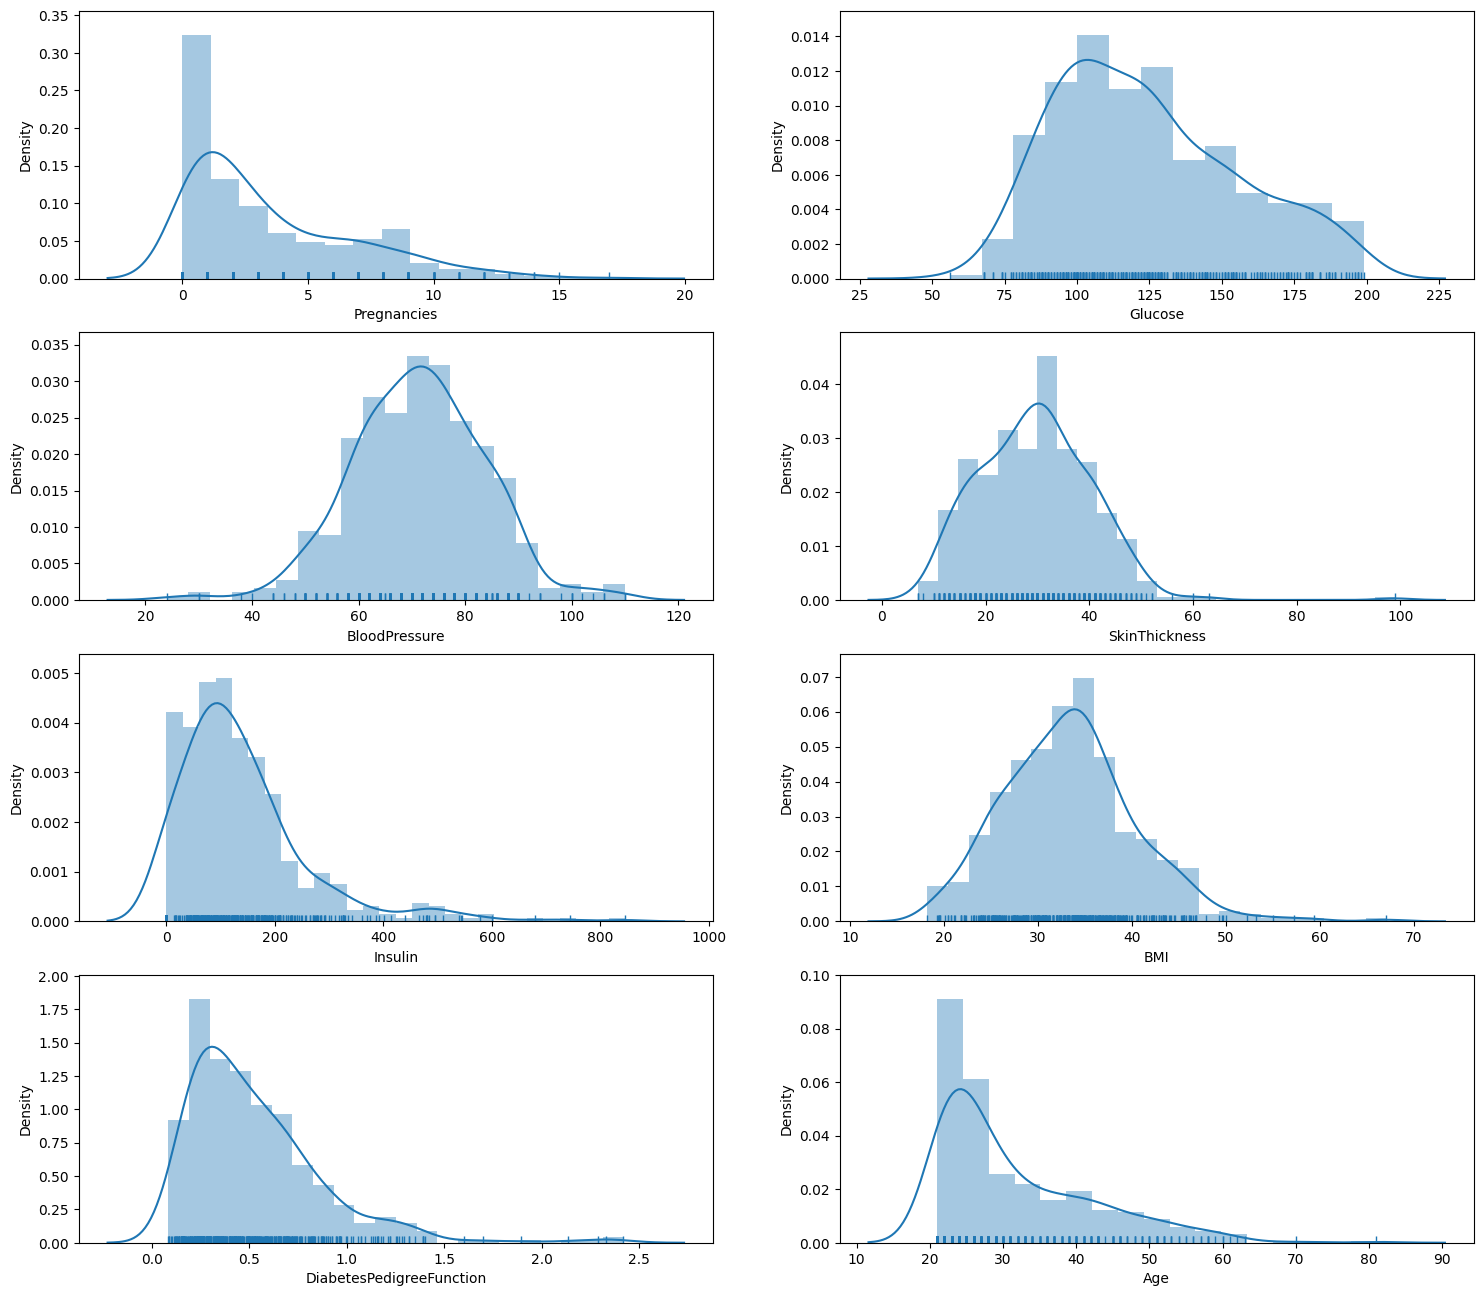

In [458]:
fig, axs = plt.subplots(4, 2, figsize=(18,16))
axs = axs.flatten()
sns.distplot(df_bin['Pregnancies'],rug=True,ax=axs[0])
sns.distplot(df_bin['Glucose'],rug=True,ax=axs[1])
sns.distplot(df_bin['BloodPressure'],rug=True,ax=axs[2])
sns.distplot(df_bin['SkinThickness'],rug=True,ax=axs[3])
sns.distplot(df_bin['Insulin'],rug=True,ax=axs[4])
sns.distplot(df_bin['BMI'],rug=True,ax=axs[5])
sns.distplot(df_bin['DiabetesPedigreeFunction'],rug=True,ax=axs[6])
sns.distplot(df_bin['Age'],rug=True,ax=axs[7])
plt.show()

In [459]:
#configuration dictionary for binning

conf = {"Pregnancies" :{
            "bins" : [-1,3,6,9,18],
            "labels": ["0-3","3-6","6-9","9+"]},

        "Glucose" :{
            "bins" : [50,100,140,np.max(df_clean["Glucose"])],
            "labels" : ["50-100","100-140","140-200"]}, #low, medium and high levels of glucose

        "BloodPressure" :{
            "bins" : [20,60,80,110],
            "labels" : ["20-60","60-80","80-110"]}, #low, medium and high levels of blood pressure

        "SkinThickness" :{
            "bins" : [6,15,30,40,np.max(df_clean["SkinThickness"])],
            "labels" : ["7-15","15-30","30-40","40+"]},

        "Insulin" : {
            "bins" : [-1,5,50,120,150,np.max(df_clean["Insulin"])],
            "labels" : ["0-5","5-50","50-120","120-150","150+"]}, #very low, low, normal, high, very high
            
        "BMI" :{
            "bins" : [18,25,30,np.max(df_clean["BMI"])],
            "labels" : ["18-25","25-30","30+"]},

        "DiabetesPedigreeFunction" :{
            "bins" : [-1,0.3,0.6,np.max(df_clean["DiabetesPedigreeFunction"])],
            "labels" : ["0-0.3","0.3-0.6","0.6+"]}, #low risk, medium risk, high risk from family history
            
        "Age" :{
            "bins" : [20,30,40,50,np.max(df_clean["Age"])],
            "labels" : ["20-30","30-40","40-50","50+"]}
        }       


In [460]:
for item in conf.keys():
    df_bin[item] = pd.cut(x=df_clean[item], bins=conf[item]["bins"],
                        labels=conf[item]["labels"])

Visualization of the binned features distributions

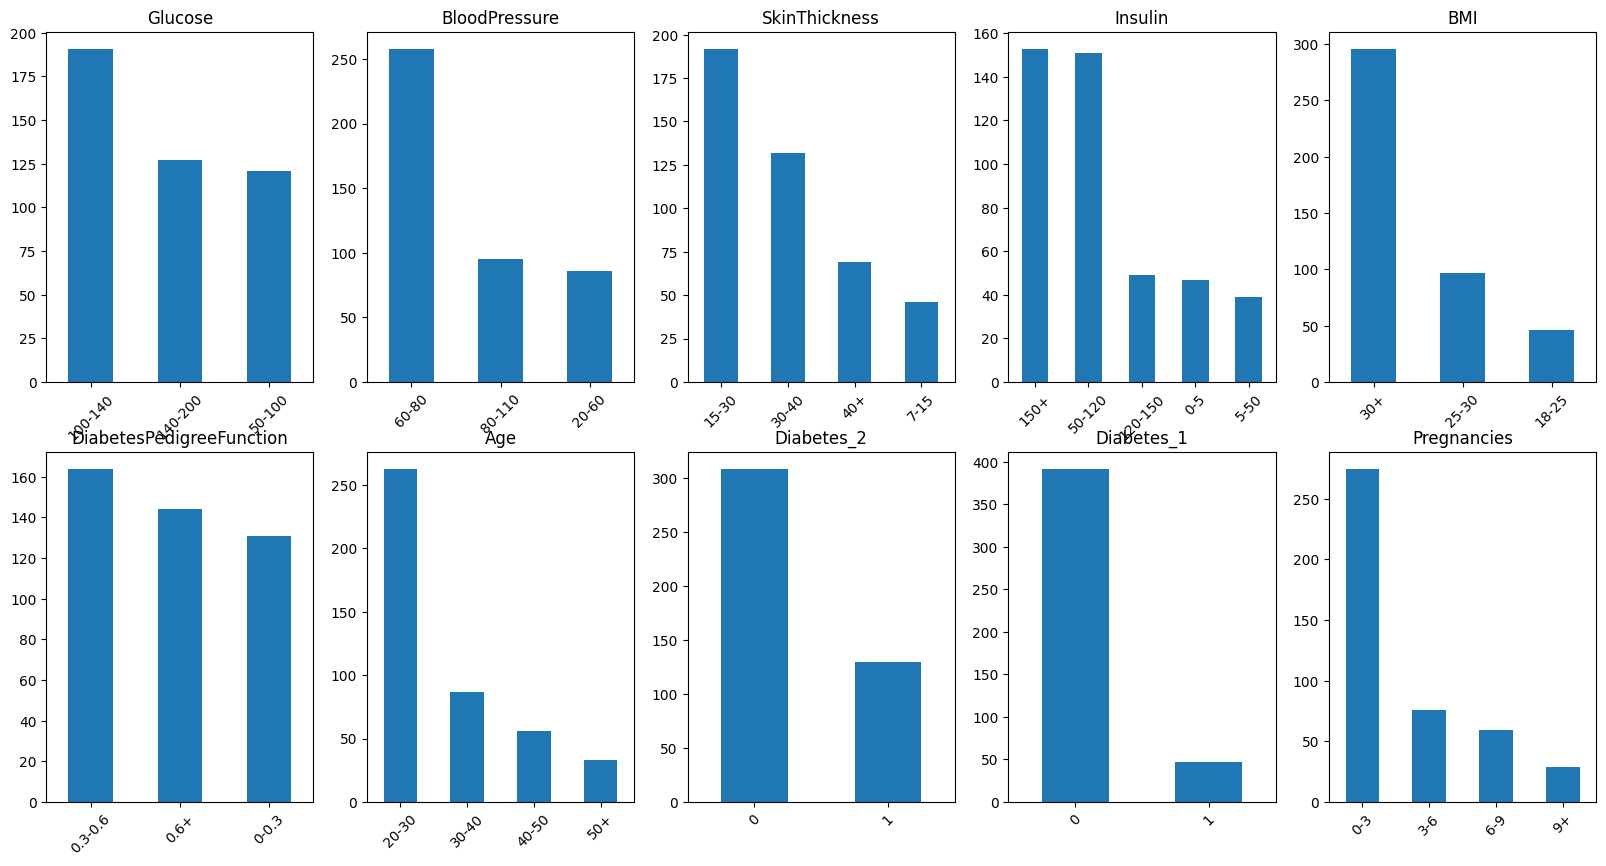

In [461]:
fig, axs = plt.subplots(2, 5, figsize=(20,10))
axs = axs.flatten()
for n,column_name in enumerate(df_bin.columns):
    df_bin[column_name].value_counts().plot(kind='bar', title = column_name, ax = axs[n-1], rot = 45)


Now that bins have been correctly created, we move on to network design

# Network


In this chapter we will build the network by analyzing both correlations between the columns of our dataframe and scientific literature (internal medicine knowledge) related to the topic. We will then explore a variety of methods related to the analysis of Bayesian Networks.  
Connections between nodes have been implemented from scratch referring to a variety of scientific medical sources. 
In the medical field causal links are particularly challenging to model (often a huge variety of features are interlaced, causing directly or indirectly effects on each others), in this work only links that have been considered particularly relevant were defined.

The connections defined will be explained below.

Analyzing the correlations between columns of the dataframe can help us reasoning about the causal relationships between them. 

<AxesSubplot: >

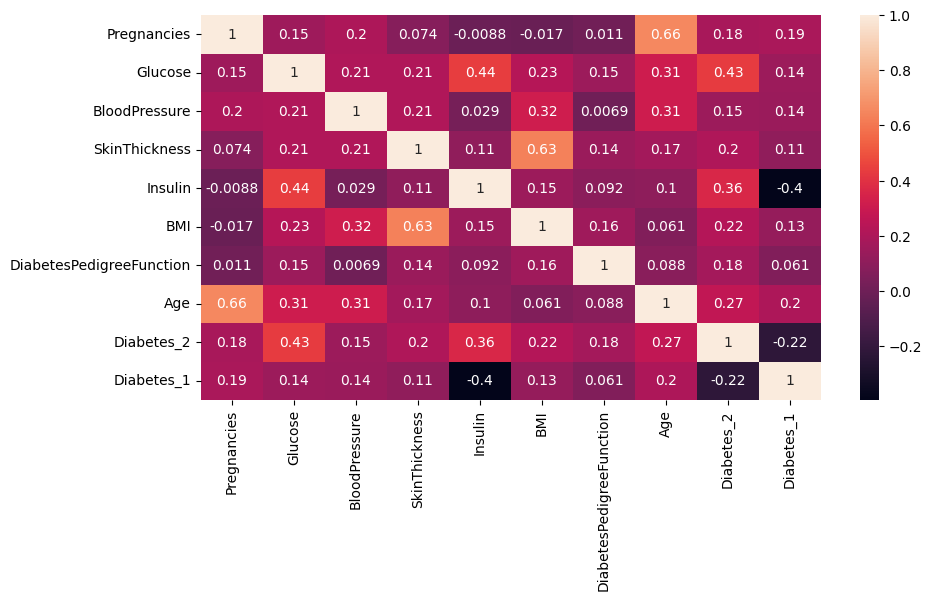

In [462]:
corr = df_clean.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True)

Let's analyze the most interesting correlations we found with the correlation matrix, we'll use these considerations to build the structure of our Bayesian Network.

- **Age - Pregnancies** : As age increases it's more likely to have had more pregnancies.
- **Diabetes_2 - Glucose** : Suffering from diabetes makes it difficult to manage blood glucose levels. The same should apply for **Diabetes_1** but we don't have such a strong correlation, we will nonetheless put this causal link in our network.
- **Glucose - Insulin**: In normal conditions glucose and insulin levels are positively correlated because our body produces insulin in response to rising levels of glucose to absorb it.  
- **BMI - BloodPressure** : It's well established in medicine literature that being overweight causes hypertension. (https://www.ahajournals.org/doi/10.1161/circresaha.116.305697)
- **Insulin - SkinThickness** : SkinThickness is a measure of how much fat is stored in skin cells. We know that insulin promotes the storage of sugars triggering the metabolic process called lipogenesis. This process is how our body converts fatty acids and glycerol into fats. This is why high levels of insulin correlate with higher SkinThickness. (https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/lipogenesis#:~:text=Insulin%20promotes%20lipogenesis%2C%20thereby%20resulting,Fig.)
- **BMI - SkinThickness** : Of course being overweight increses the chance of having more fat in the skin and vice versa.
- **Insulin - Diabetes_1** : Having type 1 diabetes means having problems producing insulin. This high negative correlation was expected since we built the Diabetes_1 column filtering for Diabetes cases with low insulin level.
- **Insulin - Diabetes_2** The same applies for Diabetes_2: it was expected to have high correlation since we selected only the cases of diabetes with not-low insulin level to build the Diabetes_2 column. Moreover, if a patient suffers from type 2 diabetes, her body still breaks down carbohydrate from her food and turns it into glucose. The pancreas then responds to this by releasing insulin. But because this insulin can't work properly, her blood sugar levels keep rising. This means more insulin is released.

### Showing the network

We show a graphical preliminary overview of the network using the visual library daft of pgmpy.  
The acronyms related to dataset attributes are the followings:

- Age: Age
- DPF: DiabetesPedigreeFunction
- BMI: BMI 
- Pr: Pregnancies
- D_2: Diabetes_2
- D_1: Diabetes_1
- Glu: Glucose
- Ins: Insulin
- ST: SkinThickness
- BP: BloodPressure




In [463]:
# %pip install daft

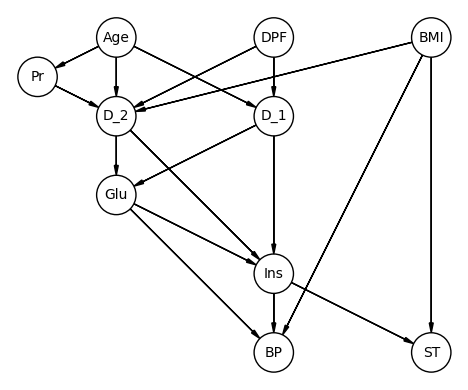

In [464]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM()

pgm.add_node(daft.Node('Age', "Age", 2, 5))
pgm.add_node(daft.Node('DPF', "DPF", 4, 5))
pgm.add_node(daft.Node('BMI', "BMI", 6, 5))

pgm.add_node(daft.Node('Pr', "Pr", 1, 4.5))

pgm.add_node(daft.Node('Diab_2', "D_2", 2, 4))
pgm.add_node(daft.Node('Diab_1', "D_1", 4, 4))

pgm.add_node(daft.Node('Glu', "Glu", 2, 3))

pgm.add_node(daft.Node('Ins', "Ins", 4, 2))

pgm.add_node(daft.Node('BP', "BP", 4, 1))
pgm.add_node(daft.Node('ST', "ST", 6, 1))

pgm.add_edge('Age', 'Pr')
pgm.add_edge('Pr', 'Diab_2')
pgm.add_edge('DPF', 'Diab_2')
pgm.add_edge('DPF', 'Diab_1')
pgm.add_edge('Age', 'Diab_2')
pgm.add_edge('Age', 'Diab_1')
pgm.add_edge('BMI','Diab_2')
pgm.add_edge('BMI','ST')
pgm.add_edge('BMI', 'BP')
pgm.add_edge('Diab_2', 'Glu')
pgm.add_edge('Diab_2', 'Ins')
pgm.add_edge('Diab_1', 'Glu')
pgm.add_edge('Diab_1', 'Ins')
pgm.add_edge('Glu', 'BP')
pgm.add_edge('Glu','Ins')
pgm.add_edge('Ins', 'BP')
pgm.add_edge('Ins','ST')

pgm.render()
plt.show()

We already explained the reason behind some of the edges of the network when we analyzed the correlation matrix, now we will discuss about the other edges we put in the network:

- **Insulin - BloodPressure**: High value of Insulin in the blood can increase blood pressure via several mechanisms: increased renal sodium reabsorption, activation of the sympathetic nervous system, alteration of transmembrane ion transport, and hypertrophy of resistance vessels. https://pubmed.ncbi.nlm.nih.gov/7512468/#:~:text=Insulin%20can%20increase%20blood%20pressure,and%20hypertrophy%20of%20resistance%20vessels.

- **Age - Diabetes_1** and **Age - Diabetes_2**: The risk of developing diabetes increases with age. This risk is present for both types of diabetes with different weight: aging has the effect of increasing insulin resistance and lower the function of insulin-producing cells in pancreas.

- **Pregnancies - Diabetes_2**: Gestational Diabetes  
This is a type of diabetes that is first seen in a pregnant woman who did not have diabetes before she was pregnant. For most women with gestational diabetes, the diabetes goes away soon after delivery. When it does not go away, the diabetes is called type 2 diabetes. Even if the diabetes does go away after the baby is born, half of all women who had gestational diabetes develop type 2 diabetes later. https://www.cdc.gov/diabetes/basics/gestational.html

- **DiabetesPedigreeFunction - Diabetes_1** and **DiabetesPedigreeFunction - Diabetes_2**: Both types of diabetes have a genetic predisposition risk factor. The Diabetes Pedigree Function is an index that takes the family history of the patient into account to predict the likelihood of diabetes insurgence.

- **Glucose - BloodPressure** : Hyperglycemia can contribute to hypertension. High blood sugar can increase blood pressure through two primary means. First, untreated hyperglycemia can lead to nerve and blood vessel damage. Damage to the blood vessels causes the walls to stiffen, narrow, and accumulate plaque. Plaque buildup narrows the vessels, increasing pressure and contributing to hypertension. Second, chronic hyperglycemia leads to chronic hyperinsulinemia, that we have already seen causes hypertension. (https://www.endocrineweb.com/conditions/diabetes/can-blood-sugar-affect-blood-pressure)

## Creating the network

In [465]:
import pgmpy
from pgmpy.models import BayesianNetwork

model = BayesianNetwork(
    [('Age','Pregnancies'),('Pregnancies', 'Diabetes_2'),('DiabetesPedigreeFunction', 'Diabetes_1'),('DiabetesPedigreeFunction', 'Diabetes_2'),
    ('Age', 'Diabetes_1'), ('Age', 'Diabetes_2'),('BMI','Diabetes_2'), ('BMI','SkinThickness'),('BMI', 'BloodPressure'),
    ('Diabetes_1', 'Glucose'),('Diabetes_1', 'Insulin'), ('Diabetes_2', 'Glucose'),('Diabetes_2', 'Insulin'),
    ('Glucose', 'BloodPressure'),('Glucose', 'Insulin'),('Insulin','BloodPressure'),('Insulin','SkinThickness')])

### Analyzing the network

Follows a series of experiments done on the network by applying a variety of methods provided by the pgmpy library, in order to see in practice all the concepts addressed during the course.

In [466]:
# Showing all the nodes of the model
model.nodes()

NodeView(('Age', 'Pregnancies', 'Diabetes_2', 'DiabetesPedigreeFunction', 'Diabetes_1', 'BMI', 'SkinThickness', 'BloodPressure', 'Glucose', 'Insulin'))

In [467]:
# Showing all the edges of the model
model.edges()

OutEdgeView([('Age', 'Pregnancies'), ('Age', 'Diabetes_1'), ('Age', 'Diabetes_2'), ('Pregnancies', 'Diabetes_2'), ('Diabetes_2', 'Glucose'), ('Diabetes_2', 'Insulin'), ('DiabetesPedigreeFunction', 'Diabetes_1'), ('DiabetesPedigreeFunction', 'Diabetes_2'), ('Diabetes_1', 'Glucose'), ('Diabetes_1', 'Insulin'), ('BMI', 'Diabetes_2'), ('BMI', 'SkinThickness'), ('BMI', 'BloodPressure'), ('Glucose', 'BloodPressure'), ('Glucose', 'Insulin'), ('Insulin', 'BloodPressure'), ('Insulin', 'SkinThickness')])

In [468]:
# Local independencies of a single node
model.local_independencies("Diabetes_1")

(Diabetes_1 ⟂ Pregnancies, BMI, Diabetes_2 | DiabetesPedigreeFunction, Age)

In [469]:
model.local_independencies("SkinThickness")

(SkinThickness ⟂ Diabetes_1, BloodPressure, Diabetes_2, DiabetesPedigreeFunction, Pregnancies, Glucose, Age | Insulin, BMI)

In [470]:
# Checking d-separation between variables with and without evidence
# Two sets of nodes X, Y are d-separated given Z if there is no active trail between any x ∈ X and y ∈ Y given Z

print(model.is_dconnected("BloodPressure", "SkinThickness"))
print(model.is_dconnected("BloodPressure", "SkinThickness",observed=["BMI"] ))
print(model.is_dconnected("BloodPressure", "SkinThickness",observed=["BMI", 'Insulin'] ))

True
True
False


In [471]:
# Function is_irrelevant recalls the definition of irrelevance given during the course 

def is_irrelevant(node1,node2,evidence):
  if ((node2 in (model.get_ancestral_graph(node1)and model.get_ancestral_graph(evidence))) and model.is_dconnected(node1, node2,observed=evidence )):
    print("Node", node1, "is not irrelevant with respect to", node2, "given the evidence", evidence)
  else:
    print("Node", node1, "is irrelevant with respect to", node2, "given the evidence", evidence)

is_irrelevant("Glucose", "Insulin", "Diabetes_1")

Node Glucose is irrelevant with respect to Insulin given the evidence Diabetes_1


In [472]:
# Checking active trails from blood pressure given the evidence diabetes
model.active_trail_nodes('BloodPressure', observed='Diabetes_1')

{'BloodPressure': {'Age',
  'BMI',
  'BloodPressure',
  'DiabetesPedigreeFunction',
  'Diabetes_2',
  'Glucose',
  'Insulin',
  'Pregnancies',
  'SkinThickness'}}

In [473]:
# Checking the markov blanket of the node BloodPressure
model.get_markov_blanket("BloodPressure")

['Glucose', 'Insulin', 'BMI']

### Parameter learning

The task of parameter estimation consists in learning the CPTs of the bayesian network, knowing its structure. We already built the structure of our network from preliminary analysis of internal medicine knowledge, now we'll use our data to find the parameters of the network.

In pgmpy are available a variety of estimators and priors to use. We will use BayesianEstimator with Bayesian Dirichlet equivalent uniform prior (BDeu). 

In [474]:
from pgmpy.estimators import BayesianEstimator

df = df_bin

In [475]:
model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print('CPT of', cpd.variable)
    print(cpd, '\n')

CPT of Age
+------------+-----------+
| Age(20-30) | 0.595158  |
+------------+-----------+
| Age(30-40) | 0.198761  |
+------------+-----------+
| Age(40-50) | 0.128941  |
+------------+-----------+
| Age(50+)   | 0.0771396 |
+------------+-----------+ 

CPT of Pregnancies
+------------------+-----+---------------------+
| Age              | ... | Age(50+)            |
+------------------+-----+---------------------+
| Pregnancies(0-3) | ... | 0.1843065693430657  |
+------------------+-----+---------------------+
| Pregnancies(3-6) | ... | 0.2427007299270073  |
+------------------+-----+---------------------+
| Pregnancies(6-9) | ... | 0.3594890510948905  |
+------------------+-----+---------------------+
| Pregnancies(9+)  | ... | 0.21350364963503649 |
+------------------+-----+---------------------+ 

CPT of Diabetes_2
+--------------------------+-----+--------------------------------+
| Age                      | ... | Age(50+)                       |
+--------------------------+--

In [476]:
# Checking the validity of the model 
# This method checks if the sum of the probabilities for each state is equal to 1 (tol=0.01) and if the CPDs associated with nodes are consistent with their parents.
model.check_model()

True

In [477]:
#Cardinality of all model nodes
model.get_cardinality()

defaultdict(int,
            {'Age': 4,
             'Pregnancies': 4,
             'Diabetes_2': 2,
             'DiabetesPedigreeFunction': 3,
             'Diabetes_1': 2,
             'BMI': 3,
             'SkinThickness': 4,
             'BloodPressure': 3,
             'Glucose': 3,
             'Insulin': 5})

## Inferences

Pgmpy allows to develop both exact and approximate inference on the Bayesian Network, in particular in this section both are presented exploring a variety of different methods related.

### Exact inference

We will perform exact inference using the Variable Elimination method as seen in class.


In [478]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

Let's see some examples of reasoning patterns: 

- Causal (prediction): given evidence from one/some ancestral node/s find the probability distribution for a descendant node.

- Evidential (explanation): given evidence on a/some descendent node/s find the probability distribution for an ancestor node. 

- Intercausal (explaining away): given evidence of a/some descendant node/s and one (or some) of its ancestors find the probability distribution for another of its ancestors.

In [479]:
#Causal inference (prediction): probability that the patient has diabetes given her number of pregnancies

print('Prior probability distribution of type 2 diabetes:')
print(infer.query(["Diabetes_2"]))

print('Probability of having type 2 diabetes with 0 to 3 pregnancies:')
print(infer.query(["Diabetes_2"],evidence={"Pregnancies": '0-3'}))

print('Probability of having type 2 diabetes with more than 9 pregnancies:')
print(infer.query(["Diabetes_2"],evidence={"Pregnancies": '9+'}))

Prior probability distribution of type 2 diabetes:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6935 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3065 |
+---------------+-------------------+
Probability of having type 2 diabetes with 0 to 3 pregnancies:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.7385 |
+---------------+-------------------+
| Diabetes_2(1) |            0.2615 |
+---------------+-------------------+
Probability of having type 2 diabetes with more than 9 pregnancies:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.4613 |
+---------------+-------------------+
| Diabetes_2(1) |            0.5387 |
+---------------+-------------------+


As expected, we can see that it is more likely to develop type 2 diabetes with a higher number of pregnancies.

In [480]:
print('Prior probability distribution of type 1 diabetes:')
print(infer.query(["Diabetes_1"]))

print('Probability of having type 1 diabetes with 0 to 3 pregnancies:')
print(infer.query(["Diabetes_1"],evidence={"Pregnancies": '0-3'}))

print('Probability of having type 1 diabetes with more than 9 pregnancies:')
print(infer.query(["Diabetes_1"],evidence={"Pregnancies": '9+'}))

Prior probability distribution of type 1 diabetes:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8878 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1122 |
+---------------+-------------------+
Probability of having type 1 diabetes with 0 to 3 pregnancies:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9212 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0788 |
+---------------+-------------------+
Probability of having type 1 diabetes with more than 9 pregnancies:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.7915 |
+---------------+-------------------+
| Diabetes_1(1) |            0.2085 |
+---------------+-------------------+


We can see that even if the node Pregnancies does not directly influence the node Diabetes_1, its effect can be observed on the latter: the probability of having diabetes_1 increses with the number of Pregnancies. This may be explained by the influence of Age over both Pregnancies and Diabetes_1.

In [481]:
#Evidential inference (explanation): probability of having diabetes knowing that the patient has very low/high insulin level
print('Prior probability distribution of type 2 diabetes:')
print(infer.query(["Diabetes_2"]))

print('Probability of having type 2 diabetes given very low insulin level:')
print(infer.query(["Diabetes_2"],evidence={"Insulin": '0-5'}))

print('Probability of having type 2 diabetes given very high insulin level:')
print(infer.query(["Diabetes_2"],evidence={"Insulin": '150+'}))

Prior probability distribution of type 2 diabetes:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6935 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3065 |
+---------------+-------------------+
Probability of having type 2 diabetes given very low insulin level:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.8938 |
+---------------+-------------------+
| Diabetes_2(1) |            0.1062 |
+---------------+-------------------+
Probability of having type 2 diabetes given very high insulin level:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.5097 |
+---------------+-------------------+
| Diabetes_2(1) |            0.4903 |
+---------------+-------------------+


In [482]:
print('Prior probability distribution of type 1 diabetes:')
print(infer.query(["Diabetes_1"]))

print('Probability of having type 1 diabetes given very low insulin level:')
print(infer.query(["Diabetes_1"],evidence={"Insulin": '0-5'}))

print('Probability of having type 1 diabetes given very high insulin level:')
print(infer.query(["Diabetes_1"],evidence={"Insulin": '150+'}))

Prior probability distribution of type 1 diabetes:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8878 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1122 |
+---------------+-------------------+
Probability of having type 1 diabetes given very low insulin level:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.0137 |
+---------------+-------------------+
| Diabetes_1(1) |            0.9863 |
+---------------+-------------------+
Probability of having type 1 diabetes given very high insulin level:
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9758 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0242 |
+---------------+-------------------+


Having a very low insulin level is almost a sure sign of having type 1 diabetes. This was expected as we built the Diabetes_1 column with this consideration in mind.

In [483]:
#Intercausal inference (explaining away): 
#How does the probability distribution of BMI changes knowing that the patient has type 2 diabetes when we also know she has another risk factor?

print('Prior probability distribution of BMI:')
print(infer.query(["BMI"]))

print('Probability distribution of BMI given that she has type 2 diabetes:')
print(infer.query(["BMI"],evidence={"Diabetes_2": 1}))

print('Probability distribution of BMI given that she has type 2 diabetes and has age over 50:')
print(infer.query(["BMI"],evidence={"Diabetes_2": 1, 'Age': '50+' }))

print('Probability distribution of BMI given that she has type 2 diabetes and has age between 20 and 30:')
print(infer.query(["BMI"],evidence={"Diabetes_2": 1, 'Age': '20-30' }))

Prior probability distribution of BMI:
+------------+------------+
| BMI        |   phi(BMI) |
+============+============+
| BMI(18-25) |     0.1074 |
+------------+------------+
| BMI(25-30) |     0.2222 |
+------------+------------+
| BMI(30+)   |     0.6704 |
+------------+------------+
Probability distribution of BMI given that she has type 2 diabetes:
+------------+------------+
| BMI        |   phi(BMI) |
+============+============+
| BMI(18-25) |     0.0704 |
+------------+------------+
| BMI(25-30) |     0.1524 |
+------------+------------+
| BMI(30+)   |     0.7771 |
+------------+------------+
Probability distribution of BMI given that she has type 2 diabetes and has age over 50:
+------------+------------+
| BMI        |   phi(BMI) |
+============+============+
| BMI(18-25) |     0.0742 |
+------------+------------+
| BMI(25-30) |     0.1847 |
+------------+------------+
| BMI(30+)   |     0.7411 |
+------------+------------+
Probability distribution of BMI given that she ha

As expected, the evidence for type 2 diabetes increases the chances that the patient is severely overweight, being obesity an important risk factor for type 2 diabetes. But if we also consider another risk factor as evidence, i.e. we know that the patient is older than 50, the probability that the patient is severly overweight decreases, since now the fact that she has diabetes may be also explained by the fact that the patient is old.
If we instead have a young patient with type 2 diabetes, it is more likely that she is severely overweight since we now know that the cause for her diabetes is surely not her age.

#### MAP queries

Maximum a posteriori (MAP) queries find the most probable configuration (called MAP configuration) of some specific variables of interest (also called MAP variable), given observations of some evidence variables.
The result of MAP queries is (in case of discrete random variables) a single value rather than a probability which encodes the instantiation of the MAP variable with higher probability given the evidence.

In [484]:
# let's see how the most likely insulin level changes as we change evidence

print(infer.map_query(["Insulin"]))
print(infer.map_query(["Insulin"], evidence={'Glucose': '50-100'}))
print(infer.map_query(["Insulin"], evidence={'Diabetes_2': 1}))
print(infer.map_query(["Insulin"], evidence={'Diabetes_1': 1}))

Eliminating: Age: 100%|██████████| 7/7 [00:00<00:00, 398.97it/s]            


{'Insulin': '50-120'}


Eliminating: Diabetes_2: 100%|██████████| 6/6 [00:00<00:00, 328.84it/s]     


{'Insulin': '50-120'}


Eliminating: Age: 100%|██████████| 6/6 [00:00<00:00, 403.80it/s]            


{'Insulin': '150+'}


Eliminating: Age: 100%|██████████| 6/6 [00:00<00:00, 356.15it/s]            

{'Insulin': '0-5'}


## Approximate Inference

Approximate Inference in pgmpy is implemented with a number of different sampling methods, in particular in this section the main focus is on the ones seen during the course: Sampling from an empty network, likelihood weighting and rejection sampling.

In [485]:
from pgmpy.inference import ApproxInference
from pgmpy.sampling import BayesianModelSampling

In [486]:
approx_infer = ApproxInference(model)
inference = BayesianModelSampling(model)

In [487]:
# Sampling from an empty network

print(approx_infer.query(variables=["Diabetes_2"], n_samples=100)) 

Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 76.08it/s]  

+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.7300 |
+---------------+-------------------+
| Diabetes_2(1) |            0.2700 |
+---------------+-------------------+


In [488]:
# Showing the convergence increasing number of samples
print(approx_infer.query(variables=["BloodPressure"], n_samples=10)) #approximate probability with a low number of samples

print(approx_infer.query(variables=["BloodPressure"], n_samples=10000)) #approximate probability with an high number of samples

print("True probability")
print(VariableElimination(model).query(["BloodPressure"]))      #true probability

Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 96.32it/s]  


+----------------------+----------------------+
| BloodPressure        |   phi(BloodPressure) |
+======================+======================+
| BloodPressure(20-60) |               0.4000 |
+----------------------+----------------------+
| BloodPressure(60-80) |               0.6000 |
+----------------------+----------------------+


Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 44.54it/s]  


+-----------------------+----------------------+
| BloodPressure         |   phi(BloodPressure) |
+=======================+======================+
| BloodPressure(20-60)  |               0.2044 |
+-----------------------+----------------------+
| BloodPressure(60-80)  |               0.5649 |
+-----------------------+----------------------+
| BloodPressure(80-110) |               0.2307 |
+-----------------------+----------------------+
True probability
+-----------------------+----------------------+
| BloodPressure         |   phi(BloodPressure) |
+=======================+======================+
| BloodPressure(20-60)  |               0.2046 |
+-----------------------+----------------------+
| BloodPressure(60-80)  |               0.5799 |
+-----------------------+----------------------+
| BloodPressure(80-110) |               0.2155 |
+-----------------------+----------------------+


We can observe that with a small number of samples we don't even find all the possible events for BloodPressure.

In [489]:
print(approx_infer.query(variables=["Diabetes_2"], n_samples=10)) #approximate probability with a low number of samples

print(approx_infer.query(variables=["Diabetes_2"], n_samples=100)) #approximate probability with a medium number of samples

print(approx_infer.query(variables=["Diabetes_2"], n_samples=10000)) #approximate probability with an high number of samples

print('True probability:')
print(VariableElimination(model).query(["Diabetes_2"]))      #true probability

Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 96.25it/s]  

+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.7000 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3000 |
+---------------+-------------------+

Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 85.48it/s]  


+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.7200 |
+---------------+-------------------+
| Diabetes_2(1) |            0.2800 |
+---------------+-------------------+


Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 46.26it/s]  


+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6882 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3118 |
+---------------+-------------------+
True probability:
+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6935 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3065 |
+---------------+-------------------+


In [490]:
#Likelihood weighting
#let's see the results of a sampling process
print(inference.likelihood_weighted_sample(size=10)) #size: number of samples


Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 83.82it/s]  

     Age Pregnancies  Diabetes_2 DiabetesPedigreeFunction  Diabetes_1    BMI  \
0  30-40         0-3           0                    0-0.3           0    30+   
1  20-30         0-3           1                     0.6+           0    30+   
2  20-30         0-3           1                    0-0.3           1    30+   
3  20-30         0-3           0                    0-0.3           0  25-30   
4  40-50         3-6           0                  0.3-0.6           0    30+   
5  30-40         3-6           0                     0.6+           0    30+   
6  20-30         0-3           0                  0.3-0.6           0    30+   
7  20-30         0-3           0                    0-0.3           0  18-25   
8  20-30         3-6           0                    0-0.3           0  18-25   
9  40-50         6-9           0                  0.3-0.6           1  25-30   

  SkinThickness BloodPressure  Glucose Insulin  _weight  
0           40+         60-80   50-100  50-120      1.0  
1  

In [491]:
# We can observe the distribution obtained to derive the approx probabilities
print(approx_infer.get_distribution(inference.likelihood_weighted_sample( size=1000), ["Diabetes_2"], joint=True))
print(approx_infer.get_distribution(inference.likelihood_weighted_sample( size=1000), ["Diabetes_1"], joint=True))

Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 76.92it/s]  


+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.6560 |
+---------------+-------------------+
| Diabetes_2(1) |            0.3440 |
+---------------+-------------------+


Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 85.89it/s]  


+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8840 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1160 |
+---------------+-------------------+


In [492]:
# Rejection sampling
print(approx_infer.get_distribution(inference.rejection_sample( size=1000), ["Diabetes_2"]))
print(approx_infer.get_distribution(inference.rejection_sample( size=1000), ["Diabetes_1"]))

Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 79.05it/s]  


+---------------+-------------------+
| Diabetes_2    |   phi(Diabetes_2) |
+===============+===================+
| Diabetes_2(0) |            0.7010 |
+---------------+-------------------+
| Diabetes_2(1) |            0.2990 |
+---------------+-------------------+


Generating for node: SkinThickness: 100%|██████████| 10/10 [00:00<00:00, 80.69it/s]  


+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8820 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1180 |
+---------------+-------------------+


We observe that, given the same number of samples, sampling from an empty network, likelihood weighting and rejection sampling give us different results. This was expected as we would need more samples to reach convergence for all theese three methods.

# Conclusions

In this final section we will explore our model to see what useful insights about diabetes, and its relation with the features of the dataset, the model has learned. We will show queries of interest and discuss about the results.

#### Query 1 : Diabetes and Glucose

In [493]:
for i in conf["Glucose"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of glucose between",i)
    print(infer.query(["Diabetes_1"],evidence={"Glucose": i}))
for i in conf["Glucose"]["labels"]:
    print("Probability of having type 2 Diabetes with a value of glucose between",i)
    print(infer.query(["Diabetes_2"],evidence={"Glucose": i}))

Probability of having type 1 Diabetes with a value of glucose between 50-100
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9270 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0730 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of glucose between 100-140
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8987 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1013 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of glucose between 140-200
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8286 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1714 |
+------

As we can see there is a close correlation between increasing glucose levels and the probability of having diabetes. This correlation is clearer with regard to type 2 diabetes, in particular we can notice that the probability of having diabetes grows considerably when the value of glucose in the blood gets high. It confirms that glucose level is a good diagnostic indicator to check if a patient suffers from diabetes.

#### Query 2: Diabetes and BMI

In [494]:
for i in conf["BMI"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of BMI between",i)
    print(infer.query(["Diabetes_1"],evidence={"BMI": i}))
for i in conf["BMI"]["labels"]:
    print("Probability of having type 2 Diabetes with a value of BMI between",i)
    print(infer.query(["Diabetes_2"],evidence={"BMI": i}))

Probability of having type 1 Diabetes with a value of BMI between 18-25
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8878 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1122 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of BMI between 25-30
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8878 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1122 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of BMI between 30+
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8878 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1122 |
+---------------+---------

As expected we don't find any difference in the probability distribution of type 1 diabetes conditioned with different BMI values: being overweight has no direct effect (it's not a risk factor) on type 1 diabetes.   
The situation of course changes when talking about type 2 diabetes: now we can see that being slightly overweight (BMI between 25 and 30) is not that impactful, but being severely overweight (BMI > 30) is.

#### Query 3: Diabetes and Age

In [495]:
for i in conf["Age"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of Age between",i)
    print(infer.query(["Diabetes_1"],evidence={"Age": i}))
for i in conf["Age"]["labels"]:
    print("Probability of having type 2 Diabetes with a value of Age between",i)
    print(infer.query(["Diabetes_2"],evidence={"Age": i}))

Probability of having type 1 Diabetes with a value of Age between 20-30
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9410 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0590 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of Age between 30-40
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8440 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1560 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of Age between 40-50
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.7462 |
+---------------+-------------------+
| Diabetes_1(1) |            0.2538 |
+---------------+-------

We can see that even if age is a risk factor for type 1 diabetes it is not that relevant. For type 2 diabetes instead, age seems to be very relevant: a person between 20-30 is almost 3 times less likely to develop type 2 diabetes than a person over 50.

#### Query 4: Diabetes and Diabetes Pedigree Function (How much does genetic influence the probability of having diabetes?)

In [496]:
for i in conf["DiabetesPedigreeFunction"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of DiabetesPedigreeFunction between",i)
    print(infer.query(["Diabetes_1"],evidence={"DiabetesPedigreeFunction": i}))
for i in conf["DiabetesPedigreeFunction"]["labels"]:
    print("Probability of having type 2 Diabetes with a value of DiabetesPedigreeFunction between",i)
    print(infer.query(["Diabetes_2"],evidence={"DiabetesPedigreeFunction": i}))

Probability of having type 1 Diabetes with a value of DiabetesPedigreeFunction between 0-0.3
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8959 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1041 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of DiabetesPedigreeFunction between 0.3-0.6
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8861 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1139 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of DiabetesPedigreeFunction between 0.6+
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8824 |
+---------------+-------------------

We can observe that the genetic component is more relevant for type 2 diabetes. This respects what we can found in medical literature: Type 2 diabetes has a stronger link to family history and lineage than type 1, and studies of twins have shown that genetics play a very strong role in the development of type 2 diabetes. (https://diabetes.org/diabetes/genetics-diabetes)

#### Query 5 : Diabetes and Blood Pressure

In [497]:
for i in conf["BloodPressure"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of BloodPressure between",i)
    print(infer.query(["Diabetes_1"],evidence={"BloodPressure": i}))
for i in conf["BloodPressure"]["labels"]:
    print("Probability of having type 2 Diabetes with a value of BloodPressure between",i)
    print(infer.query(["Diabetes_2"],evidence={"BloodPressure": i}))

Probability of having type 1 Diabetes with a value of BloodPressure between 20-60
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9350 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0650 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of BloodPressure between 60-80
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8976 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1024 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of BloodPressure between 80-110
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8168 |
+---------------+-------------------+
| Diabetes_1(1) |            0.

We notice that also high values of Blood pressure can be a signal of onset of diabetes.

#### Query 6 : Diabetes and number of pregnancies

In [498]:
for i in conf["Pregnancies"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of Pregnancies between",i)
    print(infer.query(["Diabetes_1"],evidence={"Pregnancies": i}))
for i in conf["Pregnancies"]["labels"]:
    print("Probability of having type 2 Diabetes with a value of Pregnancies between",i)
    print(infer.query(["Diabetes_2"],evidence={"Pregnancies": i}))

Probability of having type 1 Diabetes with a value of Pregnancies between 0-3
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9212 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0788 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of Pregnancies between 3-6
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8697 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1303 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of Pregnancies between 6-9
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.8065 |
+---------------+-------------------+
| Diabetes_1(1) |            0.1935 |
+-----

As the number of pregnancies for a woman grows, the same goes for the probability of developing gestational diabetes which can become type 2 diabetes. This notion of internal medicine is mirrored in our results from the model.

#### Query 7 : Diabetes and Insulin

In [499]:
for i in conf["Insulin"]["labels"]:
    print("Probability of having type 1 Diabetes with a value of Insulin between",i)
    print(infer.query(["Diabetes_1"],evidence={"Insulin": i}))
for i in conf["Insulin"]["labels"]:
    print("Probability of having type 2 Diabetes with a value of Insulin between",i)
    print(infer.query(["Diabetes_2"],evidence={"Insulin": i}))

Probability of having type 1 Diabetes with a value of Insulin between 0-5
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.0137 |
+---------------+-------------------+
| Diabetes_1(1) |            0.9863 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of Insulin between 5-50
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9166 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0834 |
+---------------+-------------------+
Probability of having type 1 Diabetes with a value of Insulin between 50-120
+---------------+-------------------+
| Diabetes_1    |   phi(Diabetes_1) |
+===============+===================+
| Diabetes_1(0) |            0.9767 |
+---------------+-------------------+
| Diabetes_1(1) |            0.0233 |
+-------------

At last but not least we get the most expected result: the correlation between the values of insulin in the blood and the probability of having diabetes. It is clear the difference in predictive significance of insulin with respect to the two diabetes. 
Of course this result is not very significant in our case for type 1 diabetes, since we manually created the columns Diabetes_1 and Diabetes_2 using insulin itself to decide to which column the patient belongs.  
It is instead more indicative with regards to type 2 diabetes (for values of insulin >5): here we can see that for high values of insulin (>120) the probability that the patient has type 2 diabetes increases considerably.

### Final considerations

To conclude, the obtained results are in line with the basic knowledge of internal medicine, confirming the validity of the produced work. It is important to emphasize that in the medicine field it is hard to work purely with neural networks, since usually what is required is not a single prediction (classification/regression task) but probabilities associated with each single possible outcome. Of course this could be obtained with neural networks as well, but with them it is impossible to set up all the causal connections between the features. For such reason bayesian networks have been useful and powerful in extrapolating the values of correlations between risk factors and diabetes in our analysis.